<a href="https://colab.research.google.com/github/rumman-adnan/Assignment-Sensors-Data/blob/main/FCN_FCN_PLUS_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data set

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# Load the training and test data
train_path = '/content/drive/MyDrive/Python work/sim_data/simu_20000_0.1_90_140_train.npy'
test_path = '/content/drive/MyDrive/Python work/sim_data/simu_10000_0.1_141_178_test.npy'
train_data = np.load(train_path)
test_data = np.load(test_path)

# Extract the sensor data and the target variables (S and D)
X_train = train_data[:, :1000]
y_train = train_data[:, -2:]
X_test = test_data[:, :1000]
y_test = test_data[:, -2:]

### Features and Labels

In [3]:
X_train_mean = np.mean(X_train, axis = 1)
X_train_mean = np.reshape(X_train_mean, (-1,1))
X_train_std = np.std(X_train, axis = 1)
X_train_std = np.reshape(X_train_std, (-1,1))
X_train = (X_train - X_train_mean)/X_train_std


X_test_mean = np.mean(X_test, axis = 1)
X_test_mean = np.reshape(X_test_mean, (-1,1))
X_test_std = np.std(X_test, axis = 1)
X_test_std = np.reshape(X_test_std, (-1,1))
X_test = (X_test - X_test_mean)/X_test_std


### FCN_Plus Model for Ssytolic BP

- Models are trained again for better results

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split

# # Load the complete training and testing data
# train_data = np.load('simu_20000_0.1_90_140_train.npy')
# test_data = np.load('simu_10000_0.1_141_178_test.npy')

# Separate features and labels
X_train_full = train_data[:, :1000]
y_train_full = train_data[:, -2]  # Only Systolic Blood Pressure
X_test = test_data[:, :1000]
y_test = test_data[:, -2]  # Only Systolic Blood Pressure

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42, shuffle=True)

# Scale the features
X_train_mean = np.mean(X_train, axis=1)
X_train_mean = np.reshape(X_train_mean, (-1, 1))
X_train_std = np.std(X_train, axis=1)
X_train_std = np.reshape(X_train_std, (-1, 1))
X_train = (X_train - X_train_mean) / X_train_std

X_val_mean = np.mean(X_val, axis=1)
X_val_mean = np.reshape(X_val_mean, (-1, 1))
X_val_std = np.std(X_val, axis=1)
X_val_std = np.reshape(X_val_std, (-1, 1))
X_val = (X_val - X_val_mean) / X_val_std

X_test_mean = np.mean(X_test, axis=1)
X_test_mean = np.reshape(X_test_mean, (-1, 1))
X_test_std = np.std(X_test, axis=1)
X_test_std = np.reshape(X_test_std, (-1, 1))
X_test = (X_test - X_test_mean) / X_test_std

# Reshape data for FCN_PLUS
X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Build the FCN_PLUS model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.Conv1D(filters=128, kernel_size=8, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(filters=256, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1)  # Single output node for Systolic Blood Pressure
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Train the model for 70 epochs and capture loss after each epoch
for epoch in range(50):
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), shuffle=False, verbose=1)

    train_loss = history.history['loss'][0]
    train_mae = history.history['mean_absolute_error'][0]

    val_loss = history.history['val_loss'][0]
    val_mae = history.history['val_mean_absolute_error'][0]

    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train MAE: {train_mae}, Val Loss: {val_loss}, Val MAE: {val_mae}, Test Loss: {test_loss}, Test MAE: {test_mae}")
    prediction = model.predict(X_test)
    mae_systolic = MeanAbsoluteError()
    mae_systolic.update_state(y_test, prediction)
    print("Mean absolute error for systolic is: ",mae_systolic.result().numpy())


438/438 [==============================] - 20s 14ms/step - loss: 8768.6826 - mean_absolute_error: 91.0489 - val_loss: 3204.9282 - val_mean_absolute_error: 54.8738
Epoch 1, Train Loss: 8768.6826171875, Train MAE: 91.04888916015625, Val Loss: 3204.92822265625, Val MAE: 54.873802185058594, Test Loss: 9582.33203125, Test MAE: 97.27973175048828
313/313 [==============================] - 1s 3ms/step
Mean absolute error for systolic is:  97.27976
438/438 [==============================] - 6s 13ms/step - loss: 991.3674 - mean_absolute_error: 25.4867 - val_loss: 2494.3137 - val_mean_absolute_error: 47.2188
Epoch 2, Train Loss: 991.367431640625, Train MAE: 25.486677169799805, Val Loss: 2494.313720703125, Val MAE: 47.21881103515625, Test Loss: 298.0421142578125, Test MAE: 14.16926097869873
313/313 [==============================] - 1s 3ms/step
Mean absolute error for systolic is:  14.169259
438/438 [==============================] - 6s 13ms/step - loss: 84.4829 - mean_absolute_error: 7.5677 - val

KeyboardInterrupt: ignored

- Mean absolute error of 4.69 is acheived

In [5]:
y_pred_s = model.predict(X_test)


313/313 [==============================] - 1s 3ms/step


In [6]:
from tensorflow.keras.metrics import mean_absolute_error

In [7]:
def calc_mae(gt, pred):
    return mean_absolute_error(gt,pred)

# list1: label; list2: prediction
def plot_2vectors(label, pred, name):
    list1 = label
    list2 = pred
    if len(list2.shape) == 2:
        mae = calc_mae(list1[:,0], list2[:,0])
    else:
        mae = calc_mae(list1, list2)

    # zipped_lists = zip(list1, list2)
    # sorted_pairs = sorted(zipped_lists)

    # tuples = zip(*sorted_pairs)
    # list1, list2 = np.array([ list(tuple) for tuple in  tuples])

    # print(list1.shape)
    # print(list2.shape)

    sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])

    plt.clf()
    plt.text(0,np.min(list2),f'MAE={mae}')

    # plt.plot(range(num_rows), list2, label=name + ' prediction')
    plt.scatter(np.arange(list2.shape[0]),list2[sorted_id],s = 1, alpha=0.5,label=f'{name} prediction', color='blue')

    plt.scatter(np.arange(list1.shape[0]),list1[sorted_id],s = 1, alpha=0.5,label=f'{name} label', color='red')

    # plt.plot(range(num_rows), list1, 'r.', label=name + ' label')
    plt.title('Prediction Results')
    plt.xlabel('Number of Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(f'{name}.png')
    print(f'Saved plot to {name}.png')
    plt.show()

In [17]:
model.save('model.h5')

In [18]:
systolic_model = model
model.save('systolic_model.h5')

In [10]:
y1=y_pred_s
print(y1)

[[183.70036]
 [177.63573]
 [155.28947]
 ...
 [163.15134]
 [163.63686]
 [161.78532]]


In [30]:
print(y_pred_s.shape)
print(y_test.shape)


(10000, 1)
(10000,)


In [64]:
y_pred_s

array([[88.15823],
       [76.66866],
       [71.53855],
       ...,
       [88.09872],
       [90.32777],
       [76.44756]], dtype=float32)

In [68]:
y_pred_s=model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [65]:
y_test_s = test_data[:, -2]  # Only Systolic Blood Pressure

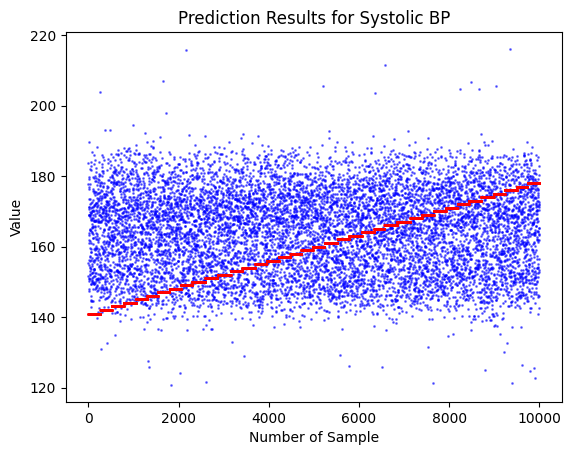

In [74]:
list1 = y_test_s
list2 = y1
sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])
sorted_id2 = sorted(range(len(list2)), key=lambda k: list1[k])
plt.clf()
# plt.text(0,np.min(list2),f'MAE={mae}')

# plt.plot(range(num_rows), list2, label=name + ' prediction')
plt.scatter(np.arange(list2.shape[0]),list2[sorted_id2],s = 1, alpha=0.5, color='blue')

plt.scatter(np.arange(list1.shape[0]),list1[sorted_id],s = 1, alpha=0.5, color='red')
plt.title('Prediction Results for Systolic BP')
plt.xlabel('Number of Sample')
plt.ylabel('Value')
plt.show()


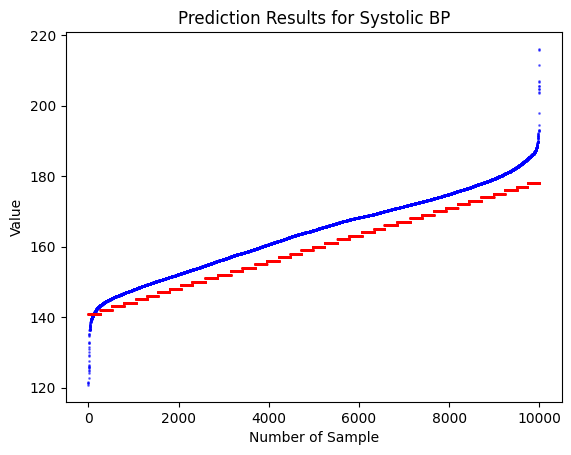

In [75]:
list1 = y_test_s
list2 = y1
sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])
sorted_id2 = sorted(range(len(list2)), key=lambda k: list2[k])
plt.clf()
# plt.text(0,np.min(list2),f'MAE={mae}')

# plt.plot(range(num_rows), list2, label=name + ' prediction')
plt.scatter(np.arange(list2.shape[0]),list2[sorted_id2],s = 1, alpha=0.5, color='blue')

plt.scatter(np.arange(list1.shape[0]),list1[sorted_id],s = 1, alpha=0.5, color='red')
plt.title('Prediction Results for Systolic BP')
plt.xlabel('Number of Sample')
plt.ylabel('Value')
plt.show()


### FCN Plus model for Diastolic BP

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split



# Separate features and labels
X_train_full = train_data[:, :1000]
y_train_full = train_data[:, -1]  # Only Diastolic Blood Pressure
X_test = test_data[:, :1000]
y_test = test_data[:, -1]  # Only Diastolic Blood Pressure

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=True)

# Scale the features
X_train_mean = np.mean(X_train, axis=1)
X_train_mean = np.reshape(X_train_mean, (-1, 1))
X_train_std = np.std(X_train, axis=1)
X_train_std = np.reshape(X_train_std, (-1, 1))
X_train = (X_train - X_train_mean) / X_train_std

X_val_mean = np.mean(X_val, axis=1)
X_val_mean = np.reshape(X_val_mean, (-1, 1))
X_val_std = np.std(X_val, axis=1)
X_val_std = np.reshape(X_val_std, (-1, 1))
X_val = (X_val - X_val_mean) / X_val_std

X_test_mean = np.mean(X_test, axis=1)
X_test_mean = np.reshape(X_test_mean, (-1, 1))
X_test_std = np.std(X_test, axis=1)
X_test_std = np.reshape(X_test_std, (-1, 1))
X_test = (X_test - X_test_mean) / X_test_std

# Reshape data for FCN_PLUS
X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

# Build the FCN_PLUS model
diastolic_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1], 1)),
    layers.Conv1D(filters=128, kernel_size=8, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(filters=256, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1)  # Single output node for Systolic Blood Pressure
])

# Compile the model
diastolic_model.compile(optimizer='adam', loss='mse', metrics=[MeanAbsoluteError()])

# Train the model for 50 epochs and capture loss after each epoch
for epoch in range(50):
    history = diastolic_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val), shuffle=False, verbose=1)

    train_loss = history.history['loss'][0]
    train_mae = history.history['mean_absolute_error'][0]

    val_loss = history.history['val_loss'][0]
    val_mae = history.history['val_mean_absolute_error'][0]

    # Evaluate the model on the test set
    test_loss, test_mae = diastolic_model.evaluate(X_test, y_test, verbose=0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train MAE: {train_mae}, Val Loss: {val_loss}, Val MAE: {val_mae}, Test Loss: {test_loss}, Test MAE: {test_mae}")
    prediction = diastolic_model.predict(X_test)
    mae_diastolic = MeanAbsoluteError()
    mae_diastolic.update_state(y_test, prediction)
    print("Mean absolute error for diastolic is: ",mae_diastolic.result().numpy())
# mae = mean_absolute_error(prediction,y_test)
# mae1 = np.mean(np.abs(y_test - prediction))
# print(f"Mean absolute error for systolic BP is: ", mae1)


500/500 [==============================] - 9s 12ms/step - loss: 3151.9446 - mean_absolute_error: 51.8022 - val_loss: 734.0588 - val_mean_absolute_error: 24.7583
Epoch 1, Train Loss: 3151.944580078125, Train MAE: 51.802181243896484, Val Loss: 734.058837890625, Val MAE: 24.758258819580078, Test Loss: 668.3538208007812, Test MAE: 23.393943786621094
313/313 [==============================] - 1s 3ms/step
Mean absolute error for diastolic is:  23.39395
500/500 [==============================] - 6s 12ms/step - loss: 126.2169 - mean_absolute_error: 8.7455 - val_loss: 89.1456 - val_mean_absolute_error: 7.3444
Epoch 2, Train Loss: 126.21685028076172, Train MAE: 8.745471000671387, Val Loss: 89.14556884765625, Val MAE: 7.344350814819336, Test Loss: 57.985816955566406, Test MAE: 6.225452423095703
313/313 [==============================] - 1s 3ms/step
Mean absolute error for diastolic is:  6.225452
500/500 [==============================] - 6s 12ms/step - loss: 31.7453 - mean_absolute_error: 4.3817 

KeyboardInterrupt: ignored

- Mean absolute error of 4.615 is acheived for diastolic BP

In [34]:
y2_pred=diastolic_model.predict(X_test)


313/313 [==============================] - 1s 3ms/step


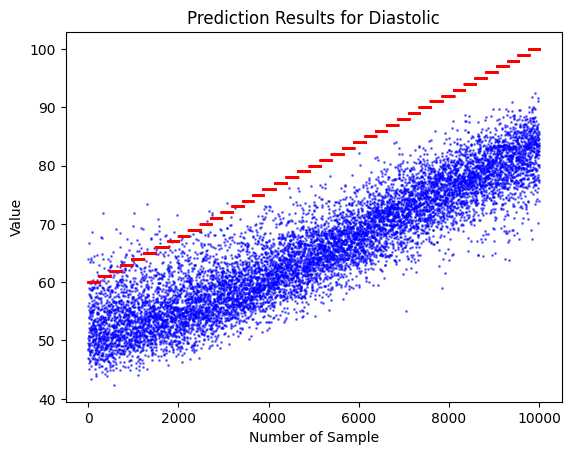

In [38]:
list1 = y_test
list2 = y2_pred
sorted_id = sorted(range(len(list1)), key=lambda k: list1[k])
plt.clf()
# plt.text(0,np.min(list2),f'MAE={mae}')

# plt.plot(range(num_rows), list2, label=name + ' prediction')
plt.scatter(np.arange(list2.shape[0]),list2[sorted_id],s = 1, alpha=0.5, color='blue')

plt.scatter(np.arange(list1.shape[0]),list1[sorted_id],s = 1, alpha=0.5, color='red')
plt.title('Prediction Results for Diastolic')
plt.xlabel('Number of Sample')
plt.ylabel('Value')
plt.show()

In [46]:
y_test

array([83., 79., 73., ..., 88., 87., 69.])

In [47]:
y2_pred

array([[67.014275],
       [66.585655],
       [53.984688],
       ...,
       [70.783516],
       [69.75519 ],
       [57.224564]], dtype=float32)